In [1]:
import os
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, ttest_ind

In [3]:
def compute_global_efficiency(fc_matrix, threshold=0.2):
    
    fc_thresh = np.copy(fc_matrix)
    fc_thresh[np.abs(fc_thresh) < threshold] = 0

    dist = 1 - np.abs(fc_thresh)
    np.fill_diagonal(dist, 0)

    G = nx.Graph()
    N = fc_thresh.shape[0]
    for i in range(N):
        for j in range(i + 1, N):
            if fc_thresh[i, j] != 0:
                G.add_edge(i, j, weight=dist[i, j])

    return nx.global_efficiency(G)

In [5]:
def compute_dlpfc_centrality(fc_matrix, node=18, threshold=0.2):
    fc_thresh = np.copy(fc_matrix)
    fc_thresh[np.abs(fc_thresh) < threshold] = 0

    dist = 1 - np.abs(fc_thresh)
    dist[np.abs(fc_thresh) == 0] = np.inf
    np.fill_diagonal(dist, 0)

    G = nx.from_numpy_array(dist)
    centrality = nx.betweenness_centrality(G, normalized=True, weight='weight')

    return centrality.get(node, np.nan)

In [7]:
data_dirs = {
    "healthy": "./healthy_groupsim_results",
    "mild_tbi": "./tbi_mildgroup_results",
    "severe_tbi": "./tbi_stronggroup_results",
    "tdcs_mild_tbi": "./tdcs_mildgroup_results",
    "tdcs_severe_tbi": "./tdcs_stronggroup_results"
}

n_subjects = 50 
all_results = []

In [9]:
for group, path in data_dirs.items():
    for i in range(n_subjects):
        try:
            fc_path = os.path.join(path, f"fc_matrix_{i}.npy")
            fc_matrix = np.load(fc_path)

            print(f"\n=== {group} subject {i} ===")
            print("FC matrix mean:", np.mean(fc_matrix))
            print("FC matrix max:", np.max(fc_matrix))
            print("FC matrix min:", np.min(fc_matrix))

            global_eff = compute_global_efficiency(fc_matrix)
            print("Computed global efficiency:", global_eff)

            dlpfc_centr = compute_dlpfc_centrality(fc_matrix)
            print("Computed DLPFC centrality:", dlpfc_centr)

            all_results.append({
                "subject_id": f"{group}_{i}",
                "group": group,
                "global_efficiency": global_eff,
                "dlpfc_betweenness": dlpfc_centr
            })

        except Exception as e:
            print(f"Error processing {group} subject {i}: {e}")


=== healthy subject 0 ===
FC matrix mean: 0.4609986900162313
FC matrix max: 1.0
FC matrix min: -0.5664709400005831
Computed global efficiency: 0.8882456140350877
Computed DLPFC centrality: 0.001081081081081081

=== healthy subject 1 ===
FC matrix mean: 0.4500175444785044
FC matrix max: 1.0
FC matrix min: -0.49816335297817793
Computed global efficiency: 0.8831578947368421
Computed DLPFC centrality: 0.0007207207207207207

=== healthy subject 2 ===
FC matrix mean: 0.4428962521106393
FC matrix max: 1.0
FC matrix min: -0.5874845119798846
Computed global efficiency: 0.8789473684210526
Computed DLPFC centrality: 0.21441441441441442

=== healthy subject 3 ===
FC matrix mean: 0.36063571607815087
FC matrix max: 1.0
FC matrix min: -0.6290048146313724
Computed global efficiency: 0.867719298245614
Computed DLPFC centrality: 0.07927927927927927

=== healthy subject 4 ===
FC matrix mean: 0.18232447669738167
FC matrix max: 1.0
FC matrix min: -0.994712640841228
Computed global efficiency: 0.8584210526

In [11]:
df_graph_metrics = pd.DataFrame(all_results)
df_graph_metrics.to_csv("graph_metrics_bygroup.csv", index=False)
print("Saved graph metrics to 'graph_metrics_bygroup.csv'")

Saved graph metrics to 'graph_metrics_bygroup.csv'


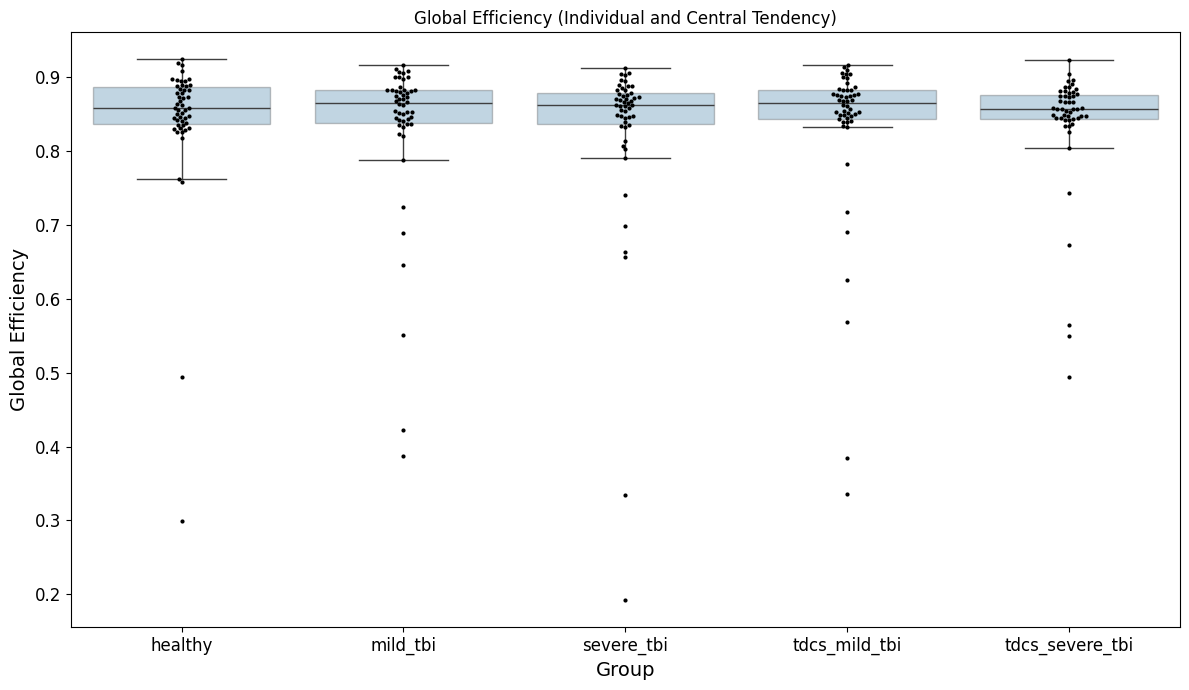

In [13]:
plt.figure(figsize=(12, 7))

sns.boxplot(
    data=df_graph_metrics,
    x="group",
    y="global_efficiency",
    showfliers=False,
    boxprops=dict(alpha=0.3)
)

sns.swarmplot(
    data=df_graph_metrics,
    x="group",
    y="global_efficiency",
    color="black",
    size=3
)

plt.title("Global Efficiency (Individual and Central Tendency)")
plt.xlabel("Group", fontsize=14)
plt.ylabel("Global Efficiency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.subplots_adjust(top=0.88)
plt.tight_layout()
plt.savefig("figures/boxplot_global_efficiency.png", dpi=300, bbox_inches='tight')
plt.show()

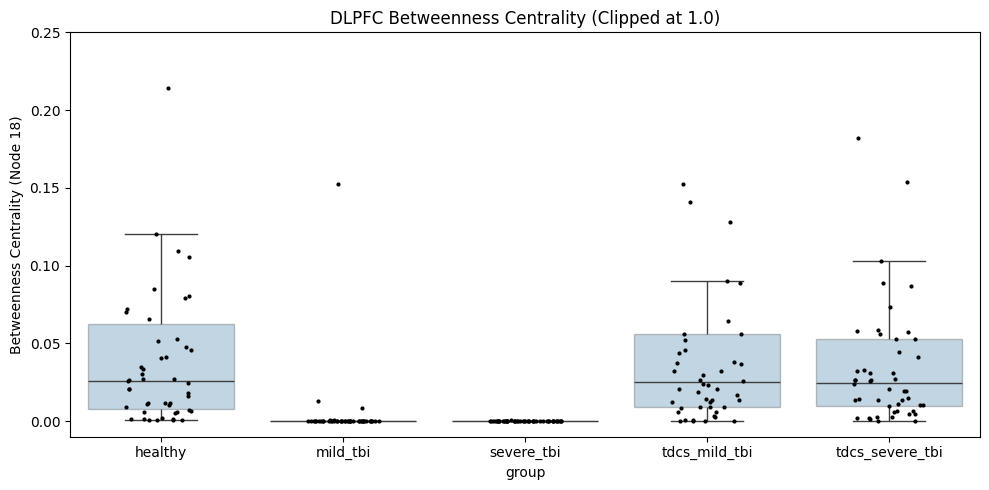

In [15]:
clip_threshold = 1.0
df_graph_metrics["dlpfc_centrality_clipped"] = df_graph_metrics["dlpfc_betweenness"].clip(upper=clip_threshold)

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_graph_metrics,
    x="group",
    y="dlpfc_centrality_clipped",
    showfliers=False,
    boxprops=dict(alpha=0.3)
)

sns.stripplot(
    data=df_graph_metrics,
    x="group",
    y="dlpfc_centrality_clipped",
    color="black",
    size=3,
    jitter=0.2
)

plt.ylim(-0.01, 0.25)
plt.title("DLPFC Betweenness Centrality (Clipped at 1.0)")
plt.ylabel("Betweenness Centrality (Node 18)")
plt.tight_layout()
plt.savefig("figures/boxplot_dlpfc_centrality.png", dpi=300, bbox_inches='tight')
plt.show()

In [17]:
groups = ["healthy", "mild_tbi", "severe_tbi", "tdcs_mild_tbi", "tdcs_severe_tbi"]
eff_vectors = [df_graph_metrics[df_graph_metrics.group == g]["global_efficiency"] for g in groups]


anova_eff = f_oneway(*eff_vectors)
print(f"ANOVA Global Efficiency: F = {anova_eff.statistic:.2f}, p = {anova_eff.pvalue:.4f}")


print("\nPost-hoc t-tests (global efficiency):")
for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        tstat, pval = ttest_ind(eff_vectors[i], eff_vectors[j])
        print(f"{groups[i]} vs {groups[j]}: t = {tstat:.2f}, p = {pval:.4f}")

ANOVA Global Efficiency: F = 0.17, p = 0.9518

Post-hoc t-tests (global efficiency):
healthy vs mild_tbi: t = 0.52, p = 0.6012
healthy vs severe_tbi: t = 0.74, p = 0.4641
healthy vs tdcs_mild_tbi: t = 0.55, p = 0.5850
healthy vs tdcs_severe_tbi: t = 0.32, p = 0.7516
mild_tbi vs severe_tbi: t = 0.25, p = 0.8060
mild_tbi vs tdcs_mild_tbi: t = 0.04, p = 0.9682
mild_tbi vs tdcs_severe_tbi: t = -0.26, p = 0.7957
severe_tbi vs tdcs_mild_tbi: t = -0.20, p = 0.8398
severe_tbi vs tdcs_severe_tbi: t = -0.50, p = 0.6151
tdcs_mild_tbi vs tdcs_severe_tbi: t = -0.29, p = 0.7696


In [19]:
cent_vectors = [df_graph_metrics[df_graph_metrics.group == g]["dlpfc_betweenness"] for g in groups]

anova_cent = f_oneway(*cent_vectors)
print(f"\nANOVA DLPFC Centrality: F = {anova_cent.statistic:.2f}, p = {anova_cent.pvalue:.4f}")

print("\nPost-hoc t-tests (DLPFC Centrality):")
for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        tstat, pval = ttest_ind(cent_vectors[i], cent_vectors[j])
        print(f"{groups[i]} vs {groups[j]}: t = {tstat:.2f}, p = {pval:.4f}")


ANOVA DLPFC Centrality: F = 0.84, p = 0.4980

Post-hoc t-tests (DLPFC Centrality):
healthy vs mild_tbi: t = -0.91, p = 0.3628
healthy vs severe_tbi: t = -0.95, p = 0.3429
healthy vs tdcs_mild_tbi: t = -0.72, p = 0.4704
healthy vs tdcs_severe_tbi: t = 1.00, p = 0.3198
mild_tbi vs severe_tbi: t = 0.04, p = 0.9656
mild_tbi vs tdcs_mild_tbi: t = 0.33, p = 0.7431
mild_tbi vs tdcs_severe_tbi: t = 1.51, p = 0.1352
severe_tbi vs tdcs_mild_tbi: t = 0.31, p = 0.7607
severe_tbi vs tdcs_severe_tbi: t = 1.65, p = 0.1032
tdcs_mild_tbi vs tdcs_severe_tbi: t = 1.59, p = 0.1159
